In [1]:
from IPython.display import clear_output
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import copy
from grid_world_v2 import GridWorld
from replay_memory import ReplayMemory

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.callbacks import Callback
from random import shuffle

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (4007, 5005))


In [109]:
class Tester(object):
    def __init__(self, env, network, weights):
        
        self.env = env
        if network == None:
            network = self.createNetwork()
        self.network = self.loadNetwork(network)
        self.loadedModel = self.loadWeights(weights, self.network)
        self.cust_episode = None
        self.Naive_Game_Histories = []
        self.Model_Game_Histories = []
        
    def loadNetwork(self,netowrk_name):
        json_file = open('models/' + str(netowrk_name), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        return loaded_model
        
    def loadWeights(self,weights_name,loadedModel):
        loadedModel.load_weights('weights/' + str(weights_name))
        return loadedModel
    
    def createNetwork(self):
        model = Sequential()
        model.add(Dense(256, init='lecun_uniform', input_shape=(self.env.observation_shape,)))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Dense(256, init='lecun_uniform'))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.env.num_actions, init='lecun_uniform'))
        model.add(Activation('linear')) 
        rms = RMSprop()
        model.compile(loss="mse", optimizer = rms)
        
        model_json = model.to_json()
        with open('models/model_' + str(self.env.grid_size) + 'x' + str(self.env.grid_size) + '.json', "w") as json_file:
            json_file.write(model_json)
            
        return 'model_' + str(self.env.grid_size) + 'x' + str(self.env.grid_size) + '.json'
            
    def loopPolicy(self, games, max_test_len):
        naive_moves, model_moves,naive_reward, model_reward = 0, 0, 0, 0
        for i in range(games):
            print 'Game: ', i
            self.env.reset()
            self.generateDemandEpisode(max_test_len + 1)
        
            #print 'Naive:'
            naive_moves = naive_moves + self.runEpisodeFixedCustomer('Naive',1)
            #naive_reward = naive_reward + self.runEpisodeFixedTime('Naive',1)
            
            #print 'Model:'
            model_moves = model_moves + self.runEpisodeFixedCustomer(self.loadedModel,0)
            #model_reward = model_reward + self.runEpisodeFixedTime(self.loadedModel,0)
            
            clear_output(wait=True)
        naive_avg_moves = naive_moves/float(games)
        model_avg_moves = model_moves/float(games)
        
        #naive_avg_reward = naive_reward/float(games)
        #model_avg_reward = model_reward/float(games)
        
        print 'Naive avg moves: ', naive_avg_moves
        print 'Model avg moves: ', model_avg_moves
        #print 'Naive avg reward: ', naive_avg_reward
        #print 'Model avg reward: ', model_avg_reward
        return (naive_avg_moves, model_avg_moves)
        
    def runEpisodeFixedCustomer(self, model, epsilon):
        terminal = False
        env_copy = copy.deepcopy(self.env)
        env_copy.reset(cust_popup_episode = self.cust_episode, cars_list = self.env.cars_list)
        while(not terminal and env_copy.t < len(self.cust_episode) - 1):
            #env_copy.print_grid()
            
            #Bookeeping
            curr_history = {}
            curr_history['t'] = env_copy.t
            curr_history['curr_state'] = (env_copy.cars_grid.copy(), env_copy.cust_grid.copy())
            
            all_agents_step = env_copy.stepAll(model,epsilon)
            
            #More Bookeeping
            curr_history['actions'] = all_agents_step
            curr_history['next_state'] = (env_copy.cars_grid.copy(), env_copy.cust_grid.copy())
            env_copy.history.append(curr_history)  
                    
            terminal = env_copy.isTerminal()
            env_copy.t += 1
            
        if model == 'Naive':
            self.Naive_Game_Histories.append(env_copy.history)
        else: 
            self.Model_Game_Histories.append(env_copy.history)
            
        return env_copy.t
    
    def runEpisodeFixedTime(self, model, epsilon):
        env_copy = copy.deepcopy(self.env)
        env_copy.reset(cust_popup_episode = self.cust_episode, cars_list = self.env.cars_list)
        episode_reward = 0
        while(env_copy.t < len(self.cust_episode) - 1):
            #env_copy.print_grid()
            
            #Bookeeping
            curr_history = {}
            curr_history['t'] = env_copy.t
            curr_history['curr_state'] = (env_copy.cars_grid.copy(), env_copy.cust_grid.copy())
            
            all_agents_step = env_copy.stepAll(model,epsilon)
            
            #More Bookeeping
            curr_history['actions'] = all_agents_step
            curr_history['next_state'] = (env_copy.cars_grid.copy(), env_copy.cust_grid.copy())
            env_copy.history.append(curr_history)  
            
            for mem in all_agents_step:
                if mem['event'] == 'pickup':
                    episode_reward = episode_reward + mem['reward']
            env_copy.t += 1
            
        if model == 'Naive':
            self.Naive_Game_Histories.append(env_copy.history)
        else: 
            self.Model_Game_Histories.append(env_copy.history)
            
        return episode_reward
    
    def generateDemandEpisode(self, timesteps):
        customer_episodes = []
        for t in range(timesteps):
            size = self.env.grid_size
            cust_popup = np.zeros((size, size))
            for i in range(size):
                for j in range(size):
                    if (random.random() < self.env.demand_init_prob[i, j]):
                        random_waittime = np.random.randint(self.env.minWaitTime, self.env.maxWaitTime+1)
                        cust_popup[i, j] = random_waittime
            customer_episodes.append(cust_popup)
        self.cust_episode = customer_episodes
        
    def print_history(self, history):
        size = self.env.grid_size
        action_options = {0: "stay", 1: "left", 2: "up", 3: "right", 4: "down"}
        for hist in history:
            cars_grid = hist["curr_state"][0]
            cust_grid = hist["curr_state"][1]
            car_events = hist["actions"]
            narrations = []
            
            print "=================================="
            print "At t = {0}".format(hist["t"])
            print " "+ "------" * (size - 1)
            state_to_print = np.zeros((size, size), dtype='<U2')
            state_to_print[state_to_print == ''] = '  '
            # customers
            state_to_print[cust_grid > 0] = 'De'
            # obstacles
            state_to_print[self.env.obstacle_grid > 0] = '@@'
            # cars
            for car in self.env.cars_list:
                state_to_print[(cars_grid) == car.carID] = 'C{0}'.format(car.carID)
            state_to_print[(cust_grid > 0) & (cars_grid > 0)] = 'CD'
            
            for car_event in car_events:
                narrations.append("C{0} chose {1}, {2} -> {3}. And its event type is {4}".format(
                        car_event['carID'], action_options[car_event['action']],
                        car_event['original_location'], car_event['new_location'], car_event['event']))
            print '| ' + '\n| '.join([' . '.join(i) + ' |' for i in state_to_print])
            print " "  + "------" * (size - 1)  
            for n in narrations:
                print n
                
        cars_grid = hist["next_state"][0]
        cust_grid = hist["next_state"][1]
        print "=================================="
        print "At final".format(hist["t"])
        print " "+ "------" * (size - 1)
        state_to_print = np.zeros((size, size), dtype='<U2')
        state_to_print[state_to_print == ''] = '  '
        # customers
        state_to_print[cust_grid > 0] = 'De'
        # obstacles
        state_to_print[self.env.obstacle_grid > 0] = '@@'
        # cars
        for car in self.env.cars_list:
            state_to_print[(cars_grid) == car.carID] = 'C{0}'.format(car.carID)
        state_to_print[(cust_grid > 0) & (cars_grid > 0)] = 'CD'
        print '| ' + '\n| '.join([' . '.join(i) + ' |' for i in state_to_print])
        print " "  + "------" * (size - 1)  
        
    def plot(self,games,max_game_length,saved_weights_freq,max_epochs, weights_name):
        epoch = []
        naive_list = []
        model_list = []
        for i in range(1, (max_epochs/saved_weights_freq) + 1 ):
            index = i * saved_weights_freq
            file_name = weights_name + '_' + str(index) + '.h5'
            self.loadedModel = self.loadWeights(file_name , self.network)
            print 'Loaded: ', file_name
            epoch.append(index)
            naive_avg_moves, model_avg_moves = tester.loopPolicy(games, max_game_length)
            naive_list.append(naive_avg_moves)
            model_list.append(model_avg_moves)
        
        #return epoch, naive_list, model_list
        plt.plot(epoch,naive_list,epoch,model_list )
        

# Test Single Model

In [110]:
obstacle_grid = np.array([[0,0,1,1,1,0,0],
              [0,0,0,1,0,0,0],
              [0,0,1,1,1,0,0],
              [0,0,0,0,0,0,0],
              [0,0,1,1,1,0,0],
              [0,0,0,1,0,0,0],
              [0,0,1,1,1,0,0]])

In [120]:
env = GridWorld(num_cars = 2, grid_size = 7, terminal_reward = 5,
                customer_rate = 0.04, demand_limit = 1, cust_wait_time = 10, obstacle_grid = obstacle_grid)
tester = Tester(env, 'model_7x7_4layer.json', 'Gridworld_7x7_4Layer_NoTD_300.h5')

In [121]:
tester.loopPolicy(500, 50)

Naive avg moves:  30.948
Model avg moves:  20.064


(30.948, 20.064)

## Plot Performance Over Epochs

Naive avg moves:  31.956
Model avg moves:  20.08


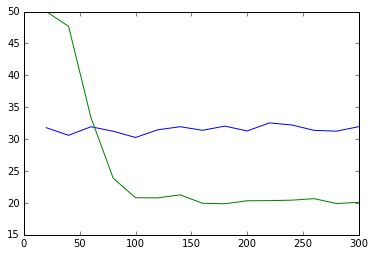

In [114]:
tester.plot(500,50,20,300,'Gridworld_7x7_4Layer_NoTD')

## Show Game History

In [176]:
tester.print_history(tester.Naive_Game_Histories[10])

At t = 0
 ------------------------------------
|    .    . @@ . @@ . @@ .    .    |
|    .    .    . @@ .    .    .    |
|    . C2 . @@ . @@ . @@ .    .    |
|    .    .    .    .    .    .    |
|    .    . @@ . @@ . @@ .    . C1 |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose right, (4, 6) -> (4, 6). And its event type is hit_wall
C2 chose up, (2, 1) -> (1, 1). And its event type is move
At t = 1
 ------------------------------------
|    .    . @@ . @@ . @@ .    .    |
|    . C2 .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    .    .    .    .    |
| De .    . @@ . @@ . @@ .    . C1 |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose left, (4, 6) -> (4, 5). And its event type is move
C2 chose down, (1, 1) -> (2, 1). And its event type is move
At t = 2
 ------------------------------------
|    .    . @@ . @@ . 

In [173]:
tester.print_history(tester.Model_Game_Histories[4])

At t = 0
 ------------------------------------
|    .    . @@ . @@ . @@ .    . C1 |
|    .    .    . @@ .    . C2 .    |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    .    .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose up, (0, 6) -> (0, 6). And its event type is hit_wall
C2 chose down, (1, 5) -> (2, 5). And its event type is move
At t = 1
 ------------------------------------
|    .    . @@ . @@ . @@ .    . C1 |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ . C2 .    |
|    .    .    .    .    .    .    |
|    .    . @@ . @@ . @@ .    . De |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose down, (0, 6) -> (1, 6). And its event type is move
C2 chose right, (2, 5) -> (2, 6). And its event type is move
At t = 2
 ------------------------------------
|    .    . @@ . @@ . 

## Cluster Situations

In [148]:
a = np.array(tester.Model_Game_Histories[2][0]['curr_state'])
b = a.reshape(1,tester.env.observation_shape/2)
print a
print b

[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  2.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]]


In [157]:
starting_states = []
for game in tester.Model_Game_Histories:
    state = np.array(game[0]['curr_state'])
    starting_states.append(state.reshape(1,tester.env.observation_shape/2)[0])
print len(starting_states)

500


In [125]:
from sklearn.cluster import KMeans

In [158]:
print starting_states[0]

[  0.   0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]


In [162]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(starting_states))

In [163]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0,

In [165]:
indices = [i for i, x in enumerate(kmeans.labels_) if x == 3]
print indices

[9, 36, 58, 95, 178, 202, 296, 361, 416, 478]


In [175]:
tester.print_history(tester.Model_Game_Histories[202])

At t = 0
 ------------------------------------
|    .    . @@ . @@ . @@ . De .    |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ . C1 . C2 |
|    .    .    .    .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose up, (2, 5) -> (1, 5). And its event type is move
C2 chose up, (2, 6) -> (1, 6). And its event type is move
At t = 1
 ------------------------------------
|    .    . @@ . @@ . @@ . De .    |
|    .    .    . @@ .    . C1 . C2 |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    .    .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
|    .    .    . @@ .    .    .    |
|    .    . @@ . @@ . @@ .    .    |
 ------------------------------------
C1 chose up, (1, 5) -> (0, 5). And its event type is pickup
C2 chose up, (1, 6) -> (0, 6). And its event type is move
At t = 2
 ------------------------------------
|    .    . @@ . @@ . @@ . C1 .